# New York City Crime

<img src=images/banner.jpg/ width="600">

# Overview

# Business Understanding

New York City crime has gone through cycles. After the 2020 pandemic, many spoke about the increase in crime and the lack of enforcement against criminal behavior. The New York City Police Department (NYPD) is the largest and one of the oldest municipal police departments in the United States. The NYPD polices a city of approximately 8.5 million people. The purpose of this project is to **assist the NYPD keep crime levels low** through machine learning. I will do this **by creating a time series model to predict crime in New York City**. 

The stakeholders for this project include the New York City Police Commissioner and the Board of Commissioners. With an understanding of crime trends and future crime predictions, the executive staff can determine a future plan for officers to prevent future crime or stop future crime as soon as possible.

In this project, I will complete the following 3 tasks:
1. **Analyze** crime trends in historical New York City crime data.
2. Create a time series model to **predict** future crime in New York city.
3. **Evaluate** the time series model and recommend next steps for the New York City Police Department.

# Data Understanding

The [data](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data) has been extracted from NYC Open Data. It includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 **(????)** to the end of 2023. There are 8,914,838 complaints reported. The data has 35 columns with reported information regarding each incident. The column descriptions can be found on the (data page)[https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data]. 



First I will import all the necessary libraries for EDA, data cleaning and modeling.

In [169]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
# Import NYPD crime data and preview the first 5 rows to ensure it was imported correctly
data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')
data.head()

/var/folders/pn/v9tvzf9s5ms7zcp53821ct0m0000gn/T/ipykernel_60127/1856452097.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,25640826H10611,12/05/2006,10:38:00,NaN,(null),NaN,12/05/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO QUEENS NORTH,(null),25-44,WHITE HISPANIC,M
1,16631501H8965,08/25/1973,12:15:00,NaN,(null),NaN,05/29/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),45-64,BLACK,F
2,11118212H8714,04/22/2006,16:50:00,NaN,(null),NaN,04/22/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),45-64,BLACK,M
3,23471265H9399,07/20/2006,22:37:00,NaN,(null),NaN,07/20/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,M
4,24565927H10142,04/14/2006,02:37:00,NaN,(null),NaN,04/14/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN NORTH,(null),45-64,BLACK,M


# Data Preparation

## Exploratory Data Analysis

In [3]:
# View the overall shape, dtypes and null counts for each column in train data
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914838 entries, 0 to 8914837
Data columns (total 35 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   CMPLNT_NUM         8914838 non-null  object 
 1   CMPLNT_FR_DT       8914183 non-null  object 
 2   CMPLNT_FR_TM       8914838 non-null  object 
 3   CMPLNT_TO_DT       7095880 non-null  object 
 4   CMPLNT_TO_TM       8914838 non-null  object 
 5   ADDR_PCT_CD        8914067 non-null  float64
 6   RPT_DT             8914838 non-null  object 
 7   KY_CD              8914838 non-null  int64  
 8   OFNS_DESC          8914838 non-null  object 
 9   PD_CD              8907245 non-null  float64
 10  PD_DESC            8914838 non-null  object 
 11  CRM_ATPT_CPTD_CD   8914838 non-null  object 
 12  LAW_CAT_CD         8914838 non-null  object 
 13  BORO_NM            8914838 non-null  object 
 14  LOC_OF_OCCUR_DESC  8914604 non-null  object 
 15  PREM_TYP_DESC      8914838 non-n

In [4]:
# Convert 'CMPLNT_NUM' to string
data['CMPLNT_NUM'] = data['CMPLNT_NUM'].astype(str)

In [5]:
# Check for duplicated using 'CMPLNT_NUM'
data['CMPLNT_NUM'].duplicated().value_counts()

CMPLNT_NUM
False    8913734
True        1104
Name: count, dtype: int64

In [6]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM', axis=0)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239715,9966585,01/02/2005,16:30:00,NaN,(null),70.0,01/02/2006,109,GRAND LARCENY,421.0,...,(null),NaN,40.642402,-73.959552,"(40.642402, -73.959552)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,F
124876,9966658,01/04/2006,15:30:00,01/05/2006,09:30:00,72.0,01/05/2006,341,PETIT LARCENY,321.0,...,(null),NaN,40.661648,-73.981201,"(40.661648, -73.981201)",PATROL BORO BKLYN SOUTH,(null),45-64,WHITE,M
378931,9966757,12/15/2005,11:00:00,NaN,(null),75.0,01/03/2006,353,UNAUTHORIZED USE OF A VEHICLE,462.0,...,M,NaN,40.671360,-73.881811,"(40.6713598203364, -73.8818110231735)",PATROL BORO BKLYN NORTH,(null),18-24,BLACK,F
48564,9966791,01/04/2006,08:55:00,01/04/2006,09:00:00,76.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.683651,-74.000304,"(40.6836512406856, -74.0003043120176)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,F


In [7]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM').head(20)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
515607,10015119,01/05/2006,20:30:00,01/07/2006,02:00:00,45.0,01/07/2006,107,BURGLARY,224.0,...,(null),NaN,40.824741,-73.821517,"(40.824741, -73.821517)",PATROL BORO BRONX,(null),25-44,WHITE HISPANIC,F
358705,10015262,01/04/2006,16:48:00,01/04/2006,16:48:00,49.0,01/04/2006,236,DANGEROUS WEAPONS,782.0,...,(null),NaN,40.856577,-73.843894,"(40.8565767275976, -73.8438936779283)",PATROL BORO BRONX,(null),(null),UNKNOWN,E
467185,10015321,01/03/2006,18:00:00,01/03/2006,19:00:00,50.0,01/03/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,NaN,40.882862,-73.903574,"(40.8828621313214, -73.9035744897024)",PATROL BORO BRONX,(null),65+,WHITE,F
489184,10015453,01/07/2006,21:46:00,01/07/2006,21:56:00,115.0,01/07/2006,113,FORGERY,723.0,...,(null),NaN,40.756568,-73.875932,"(40.7565675846374, -73.8759315341335)",PATROL BORO QUEENS NORTH,(null),(null),UNKNOWN,E
467859,10016512,01/04/2006,10:00:00,01/04/2006,23:00:00,113.0,01/05/2006,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,(null),NaN,40.674323,-73.789208,"(40.674323, -73.789208)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F


In [8]:
# View year range of data
## TO DO

In [9]:
data['LAW_CAT_CD'].value_counts().index[1]

'FELONY'

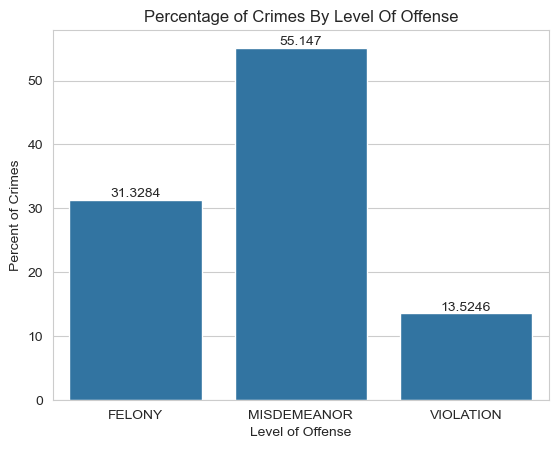

In [10]:
# Visualize crimes by level of offense
ax = sns.countplot(x="LAW_CAT_CD", data=data, stat='percent')
ax.set_xlabel('Level of Offense')
ax.set_ylabel('Percent of Crimes')
ax.set_title('Percentage of Crimes By Level Of Offense')
ax.bar_label(ax.containers[0]);

In [11]:
# View the different types of crime descriptions
data['OFNS_DESC'].value_counts()

OFNS_DESC
PETIT LARCENY                      1556946
HARRASSMENT 2                      1187346
ASSAULT 3 & RELATED OFFENSES        935330
CRIMINAL MISCHIEF & RELATED OF      876668
GRAND LARCENY                       783519
                                    ...   
FORTUNE TELLING                         13
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           5
UNDER THE INFLUENCE OF DRUGS             3
KIDNAPPING AND RELATED OFFENSES          3
Name: count, Length: 73, dtype: int64

# INSERT SAMPLE DATA TO PLAY WITH

In [12]:
# Create a sample of the data to work with to decrease runtime
data_sample = data.sample(5000)
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
7837006,251500748,09/21/2022,15:00:00,09/21/2022,20:00:00,123.0,09/23/2022,341,PETIT LARCENY,313.0,...,M,NaN,40.511452,-74.238439,"(40.511452, -74.238439)",PATROL BORO STATEN ISLAND,(null),18-24,WHITE,F
8833683,275774053,10/11/2023,16:29:00,10/11/2023,16:32:00,47.0,10/11/2023,343,OTHER OFFENSES RELATED TO THEF,478.0,...,M,12.0,40.903481,-73.850341,"(40.90348104720813, -73.85034060870207)",PATROL BORO BRONX,241 ST.-WAKEFIELD,UNKNOWN,UNKNOWN,E
4827379,144705145,07/22/2015,01:30:00,07/22/2015,01:35:00,63.0,07/22/2015,678,MISCELLANEOUS PENAL LAW,201.0,...,(null),NaN,40.617325,-73.934826,"(40.617325, -73.934826)",PATROL BORO BKLYN SOUTH,(null),45-64,WHITE,F
6460432,174137773,01/27/2018,22:02:00,01/27/2018,22:05:00,107.0,01/27/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,M,NaN,40.735434,-73.787147,"(40.735434, -73.787147)",PATROL BORO QUEENS SOUTH,(null),18-24,WHITE,M
2463513,73723424,07/17/2010,05:00:00,07/17/2010,05:05:00,69.0,07/17/2010,105,ROBBERY,397.0,...,M,NaN,40.649542,-73.899470,"(40.64954185, -73.89947047)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,M


In [13]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 7837006 to 4040307
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CMPLNT_NUM         5000 non-null   object 
 1   CMPLNT_FR_DT       5000 non-null   object 
 2   CMPLNT_FR_TM       5000 non-null   object 
 3   CMPLNT_TO_DT       3940 non-null   object 
 4   CMPLNT_TO_TM       5000 non-null   object 
 5   ADDR_PCT_CD        5000 non-null   float64
 6   RPT_DT             5000 non-null   object 
 7   KY_CD              5000 non-null   int64  
 8   OFNS_DESC          5000 non-null   object 
 9   PD_CD              4996 non-null   float64
 10  PD_DESC            5000 non-null   object 
 11  CRM_ATPT_CPTD_CD   5000 non-null   object 
 12  LAW_CAT_CD         5000 non-null   object 
 13  BORO_NM            5000 non-null   object 
 14  LOC_OF_OCCUR_DESC  5000 non-null   object 
 15  PREM_TYP_DESC      5000 non-null   object 
 16  JURIS_DESC         5

In [25]:
top_10_off_desc = data_sample.groupby('OFNS_DESC').size().sort_values(ascending=False).head(10)

In [26]:
top_10_off_desc

OFNS_DESC
PETIT LARCENY                     907
HARRASSMENT 2                     659
ASSAULT 3 & RELATED OFFENSES      509
CRIMINAL MISCHIEF & RELATED OF    482
GRAND LARCENY                     442
DANGEROUS DRUGS                   255
OFF. AGNST PUB ORD SENSBLTY &     252
FELONY ASSAULT                    220
ROBBERY                           183
BURGLARY                          156
dtype: int64

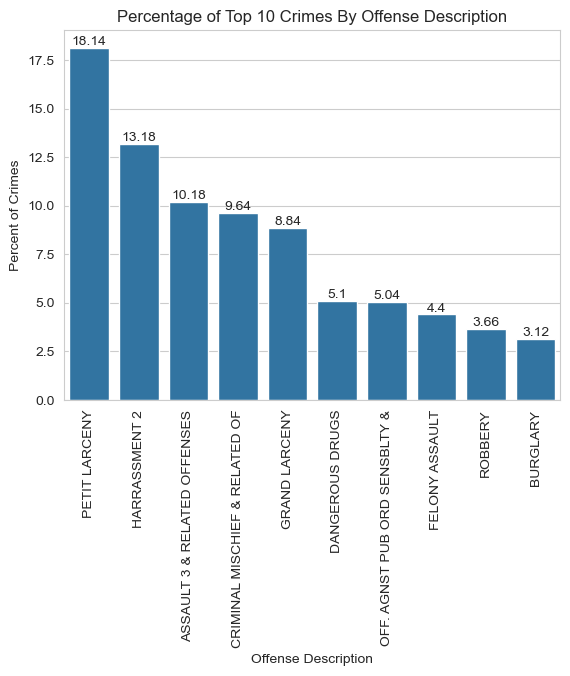

In [43]:
# Visualize crimes by offense description
ax = sns.countplot(data=data_sample, 
                   x='OFNS_DESC', 
                   stat='percent',
                  order=data_sample['OFNS_DESC'].value_counts(ascending=False).iloc[:10].index)
ax.set_xlabel('Offense Description')
plt.xticks(rotation=90)
ax.set_ylabel('Percent of Crimes')
ax.set_title('Percentage of Top 10 Crimes By Offense Description')
ax.bar_label(ax.containers[0]);

In [48]:
data.index

RangeIndex(start=0, stop=8914838, step=1)

In [53]:
# Create and set datetime object
data_sample['CMPLNT_FR_DT'] = pd.to_datetime(data_sample['CMPLNT_FR_DT'], format='%m/%d/%Y')

In [68]:
# Set index as datetime
data_sample = data_sample.set_index(data_sample['CMPLNT_FR_DT'], drop=True).sort_index()
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2002-09-01,23448339,2002-09-01,07:00:00,06/30/2006,15:00:00,23.0,07/19/2006,109,GRAND LARCENY,438.0,...,(null),NaN,40.799045,-73.947642,"(40.799045, -73.947642)",PATROL BORO MAN NORTH,(null),45-64,BLACK,F
2003-10-01,73357961,2003-10-01,09:00:00,08/31/2009,23:00:00,45.0,06/23/2010,109,GRAND LARCENY,438.0,...,(null),NaN,40.830890,-73.827284,"(40.8308903, -73.82728416)",PATROL BORO BRONX,(null),(null),UNKNOWN,D
2004-01-01,206834601,2004-01-01,08:00:00,12/31/2011,23:59:00,72.0,12/24/2019,116,SEX CRIMES,168.0,...,M,NaN,40.658158,-74.000441,"(40.6581577535544, -74.0004411548878)",PATROL BORO BKLYN SOUTH,(null),18-24,WHITE HISPANIC,F
2005-01-01,77734513,2005-01-01,15:00:00,12/01/2005,15:00:00,70.0,03/14/2011,116,SEX CRIMES,179.0,...,M,NaN,40.630600,-73.973705,"(40.6305998504358, -73.9737053160275)",PATROL BORO BKLYN SOUTH,(null),<18,BLACK,F
2005-03-02,10164824,2005-03-02,19:00:00,03/05/2005,16:00:00,105.0,01/22/2006,109,GRAND LARCENY,405.0,...,(null),NaN,40.664901,-73.751733,"(40.664901, -73.751733)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,M


In [55]:
# Delete
data_sample.index

DatetimeIndex(['2022-09-21', '2023-10-11', '2015-07-22', '2018-01-27',
               '2010-07-17', '2021-10-18', '2023-09-26', '2021-11-26',
               '2011-04-06', '2012-05-01',
               ...
               '2010-03-29', '2010-09-20', '2021-05-14', '2008-10-27',
               '2006-11-11', '2021-03-28', '2020-07-23', '2009-07-15',
               '2022-08-15', '2013-06-21'],
              dtype='datetime64[ns]', name='CMPLNT_FR_DT', length=5000, freq=None)

In [60]:
data['CMPLNT_FR_DT'] = pd.to_datetime(data['CMPLNT_FR_DT'])

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 11/19/1015, at position 4697572. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [59]:
dt_data.index

Index(['01/01/1948', '01/01/1955', '01/01/1955', '01/01/1961', '01/01/1964',
       '01/01/1964', '01/01/1965', '01/01/1967', '01/01/1967', '01/01/1967',
       ...
                nan,          nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,          nan],
      dtype='object', name='CMPLNT_FR_DT', length=8914838)

In [55]:
dt_data = data.set_index(data['CMPLNT_FR_DT'], drop=True).sort_index()
dt_data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
01/01/1948,47950156,01/01/1948,04:00:00,06/28/2008,02:51:00,105.0,07/02/2008,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.694620,-73.735327,"(40.69462, -73.735327)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F
01/01/1955,226616730,01/01/1955,00:01:00,12/31/1957,00:59:00,123.0,04/07/2021,116,SEX CRIMES,177.0,...,(null),NaN,40.512038,-74.249755,"(40.5120382535219, -74.2497549524458)",PATROL BORO STATEN ISLAND,(null),65+,WHITE,F
01/01/1955,221569468,01/01/1955,10:00:00,01/01/1967,10:00:00,62.0,12/09/2020,116,SEX CRIMES,177.0,...,M,NaN,40.602216,-74.002951,"(40.6022161657077, -74.0029507988395)",PATROL BORO BKLYN SOUTH,(null),65+,WHITE,F
01/01/1961,249596456,01/01/1961,00:00:00,12/31/1961,23:59:00,19.0,08/15/2022,116,SEX CRIMES,177.0,...,(null),NaN,40.766996,-73.963922,"(40.7669956423899, -73.9639223035387)",PATROL BORO MAN NORTH,(null),65+,WHITE,M
01/01/1964,252593706,01/01/1964,00:01:00,NaN,(null),42.0,10/14/2022,116,SEX CRIMES,177.0,...,M,NaN,40.822271,-73.911698,"(40.8222710411331, -73.911697780277)",PATROL BORO BRONX,(null),45-64,UNKNOWN,M


In [69]:
# Delete
data_sample.index[0].day

1

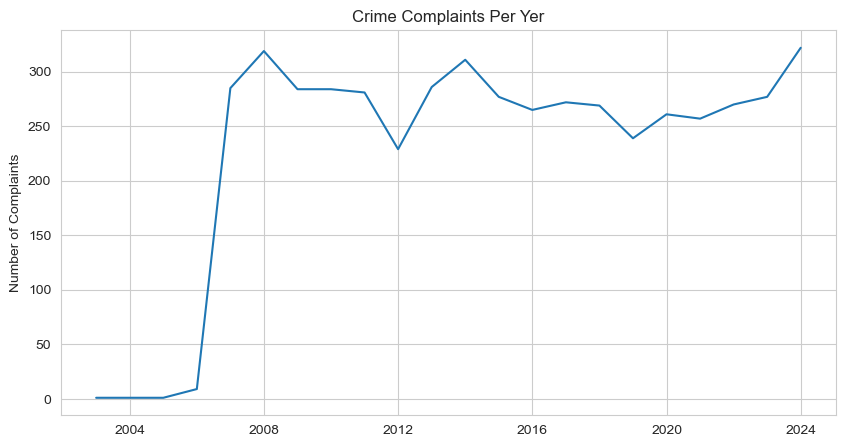

In [64]:
# Resample data to yearly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_sample_yearly = data_sample.resample('YE').count()['CMPLNT_FR_DT']
ax.plot(data_sample_yearly.index, data_sample_yearly.values)
ax.set_title('Crime Complaints Per Yer')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above time plot

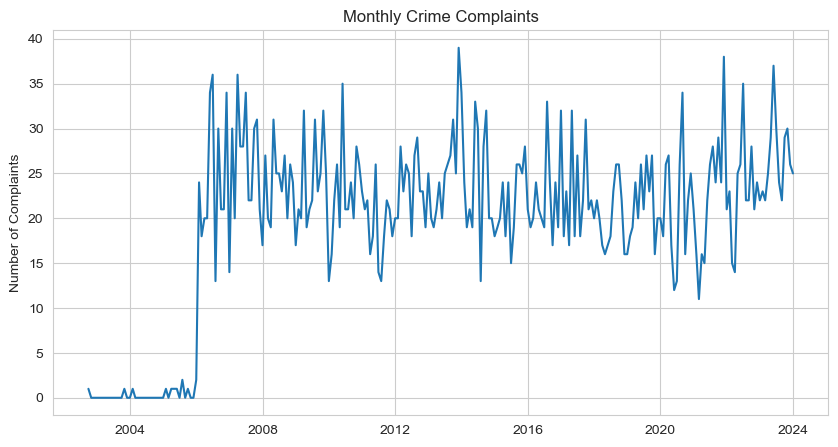

In [158]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_sample_monthly = data_sample.resample('ME').count()['CMPLNT_FR_DT']
ax.plot(data_sample_monthly.index, data_sample_monthly.values)
ax.set_title('Monthly Crime Complaints')
ax.set_ylabel('Number of Complaints');

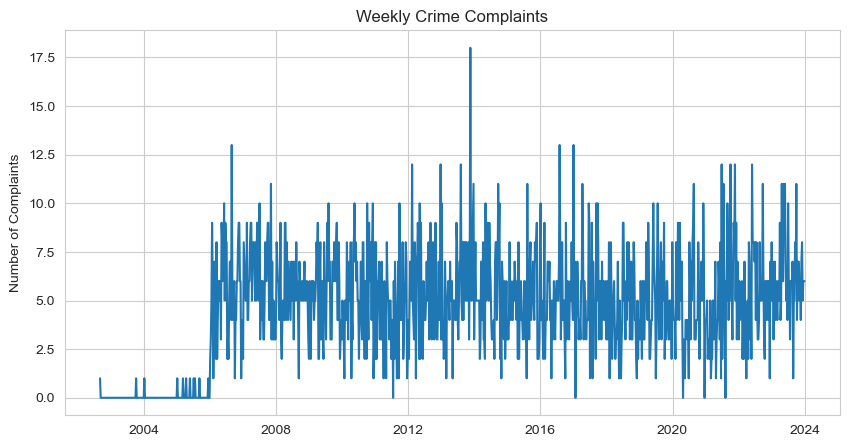

In [177]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_sample_weekly = data_sample.resample('W').count()['CMPLNT_FR_DT']
ax.plot(data_sample_weekly.index, data_sample_weekly.values)
ax.set_title('Weekly Crime Complaints')
ax.set_ylabel('Number of Complaints');

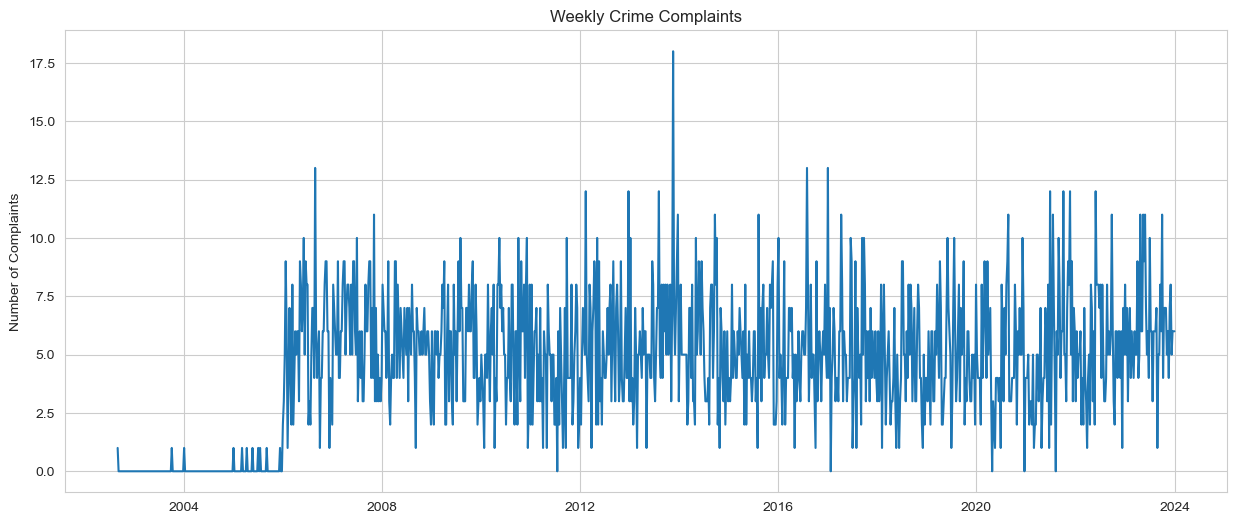

In [191]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(15, 6))
data_sample_weekly = data_sample.resample('W').count()['CMPLNT_FR_DT']
ax.plot(data_sample_weekly.index, data_sample_weekly.values)
ax.set_title('Weekly Crime Complaints')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above time plot

In [84]:
# Create column to sort complaints by month
data_sample['Month'] = data_sample.index.month
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Month
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2002-09-01,23448339,2002-09-01,07:00:00,06/30/2006,15:00:00,23.0,07/19/2006,109,GRAND LARCENY,438.0,...,NaN,40.799045,-73.947642,"(40.799045, -73.947642)",PATROL BORO MAN NORTH,(null),45-64,BLACK,F,9
2003-10-01,73357961,2003-10-01,09:00:00,08/31/2009,23:00:00,45.0,06/23/2010,109,GRAND LARCENY,438.0,...,NaN,40.830890,-73.827284,"(40.8308903, -73.82728416)",PATROL BORO BRONX,(null),(null),UNKNOWN,D,10
2004-01-01,206834601,2004-01-01,08:00:00,12/31/2011,23:59:00,72.0,12/24/2019,116,SEX CRIMES,168.0,...,NaN,40.658158,-74.000441,"(40.6581577535544, -74.0004411548878)",PATROL BORO BKLYN SOUTH,(null),18-24,WHITE HISPANIC,F,1
2005-01-01,77734513,2005-01-01,15:00:00,12/01/2005,15:00:00,70.0,03/14/2011,116,SEX CRIMES,179.0,...,NaN,40.630600,-73.973705,"(40.6305998504358, -73.9737053160275)",PATROL BORO BKLYN SOUTH,(null),<18,BLACK,F,1
2005-03-02,10164824,2005-03-02,19:00:00,03/05/2005,16:00:00,105.0,01/22/2006,109,GRAND LARCENY,405.0,...,NaN,40.664901,-73.751733,"(40.664901, -73.751733)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,M,3


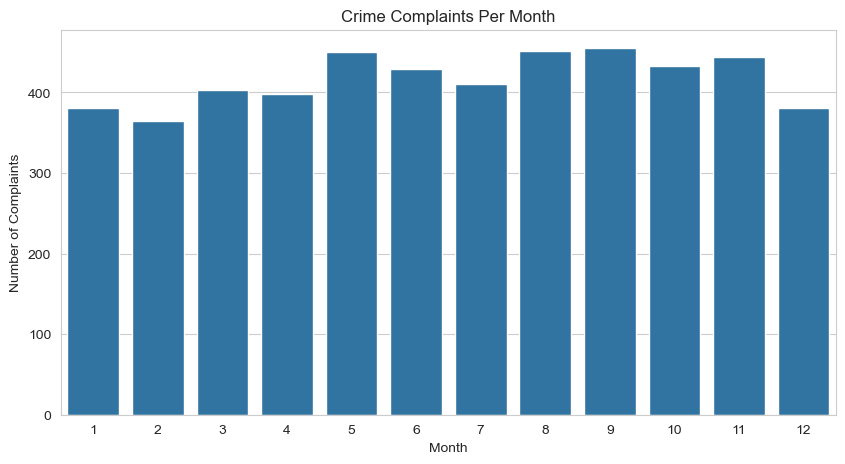

In [110]:
# Plot bar chart of number of complaints per month

x = data_sample['Month'].value_counts().index
y = data_sample['Month'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Month')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

In [148]:
# Create column to sort complaints by hour of occurence
data_sample['Hour'] = data_sample['CMPLNT_FR_TM']
data_sample['Hour'] = data_sample['Hour'].apply(lambda x: x[:2])
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data_sample.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Month,Hour
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2002-09-01,23448339,2002-09-01,07:00:00,06/30/2006,15:00:00,23.0,07/19/2006,109,GRAND LARCENY,438.0,...,40.799045,-73.947642,"(40.799045, -73.947642)",PATROL BORO MAN NORTH,(null),45-64,BLACK,F,9,07
2003-10-01,73357961,2003-10-01,09:00:00,08/31/2009,23:00:00,45.0,06/23/2010,109,GRAND LARCENY,438.0,...,40.830890,-73.827284,"(40.8308903, -73.82728416)",PATROL BORO BRONX,(null),(null),UNKNOWN,D,10,09
2004-01-01,206834601,2004-01-01,08:00:00,12/31/2011,23:59:00,72.0,12/24/2019,116,SEX CRIMES,168.0,...,40.658158,-74.000441,"(40.6581577535544, -74.0004411548878)",PATROL BORO BKLYN SOUTH,(null),18-24,WHITE HISPANIC,F,1,08
2005-01-01,77734513,2005-01-01,15:00:00,12/01/2005,15:00:00,70.0,03/14/2011,116,SEX CRIMES,179.0,...,40.630600,-73.973705,"(40.6305998504358, -73.9737053160275)",PATROL BORO BKLYN SOUTH,(null),<18,BLACK,F,1,15
2005-03-02,10164824,2005-03-02,19:00:00,03/05/2005,16:00:00,105.0,01/22/2006,109,GRAND LARCENY,405.0,...,40.664901,-73.751733,"(40.664901, -73.751733)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,M,3,19


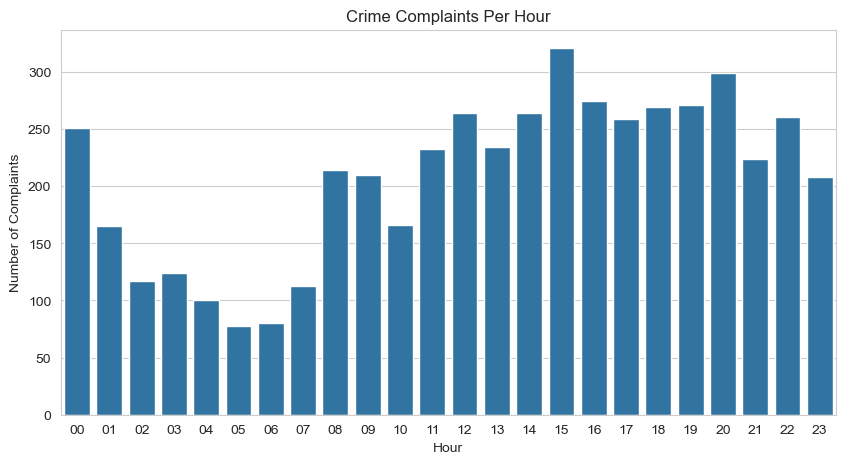

In [155]:
# Plot bar chart of number of complaints per hour

x = data_sample['Hour'].value_counts().index
y = data_sample['Hour'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y, order=x.sort_values())
ax.set_title('Crime Complaints Per Hour')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

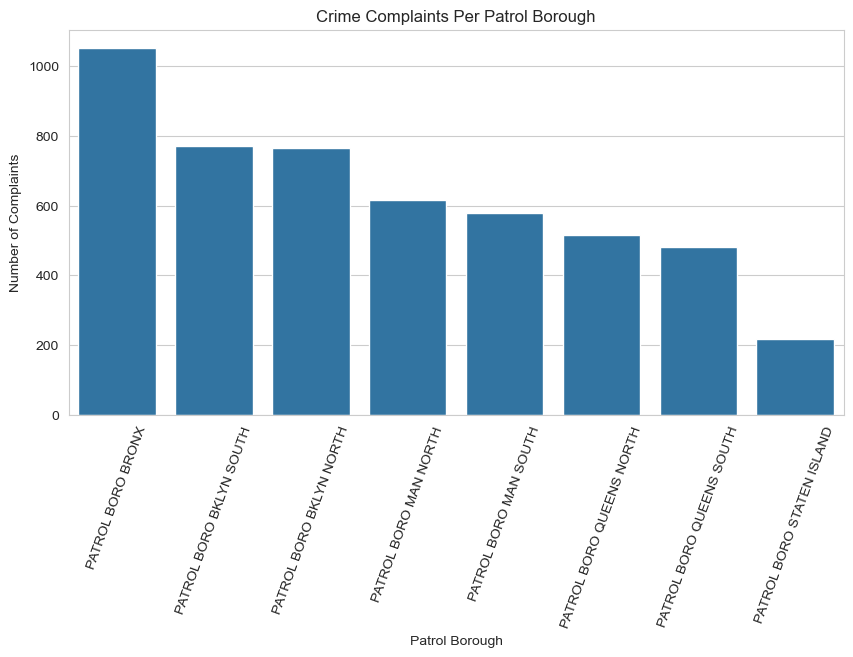

In [120]:
# Plot bar chart of number of complaints per patrol borough

x = data_sample['PATROL_BORO'].value_counts().index
y = data_sample['PATROL_BORO'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Patrol Borough')
plt.xticks(rotation=70)
ax.set_xlabel('Patrol Borough')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

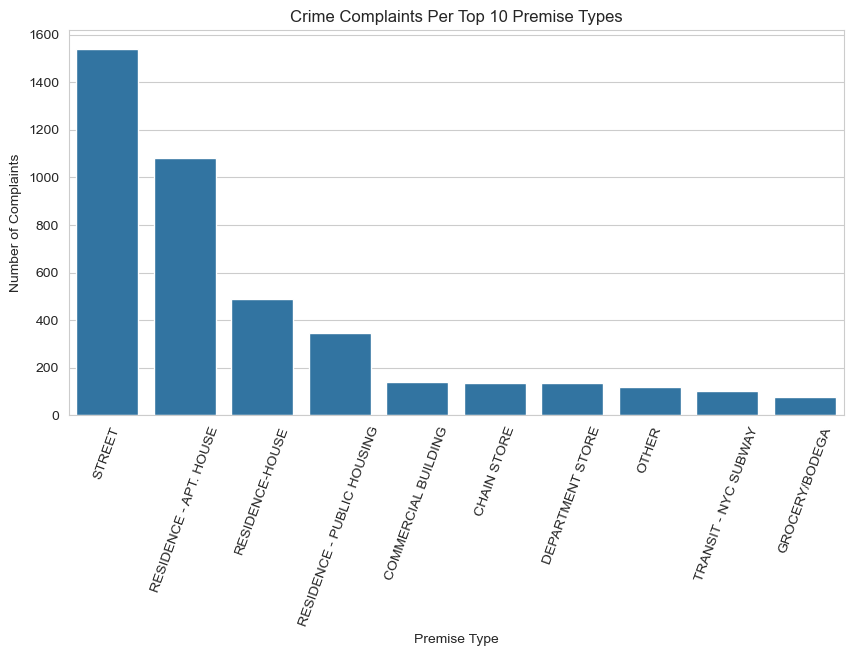

In [133]:
# Plot bar chart of number of complaints per premise type description

x = data_sample['PREM_TYP_DESC'].value_counts().index[:10]
y = data_sample['PREM_TYP_DESC'].value_counts().values[:10]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Top 10 Premise Types')
plt.xticks(rotation=70)
ax.set_xlabel('Premise Type')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

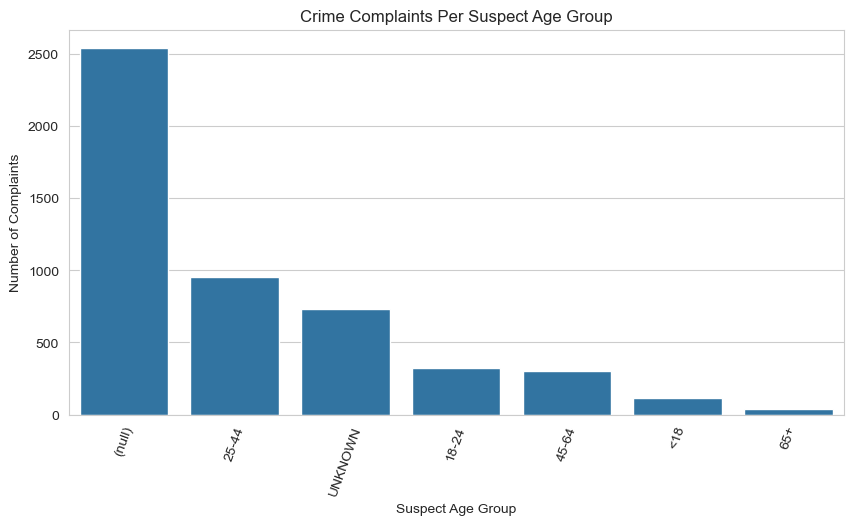

In [121]:
# Plot bar chart of number of complaints per suspect age group

x = data_sample['SUSP_AGE_GROUP'].value_counts().index
y = data_sample['SUSP_AGE_GROUP'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Age Group')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Age Group')
ax.set_ylabel('Number of Complaints');

In [122]:
data_sample['SUSP_AGE_GROUP'].value_counts()

SUSP_AGE_GROUP
(null)     2540
25-44       952
UNKNOWN     730
18-24       323
45-64       301
<18         118
65+          36
Name: count, dtype: int64

##TO DO
Add summary of above bar plot

NOT USEFUL

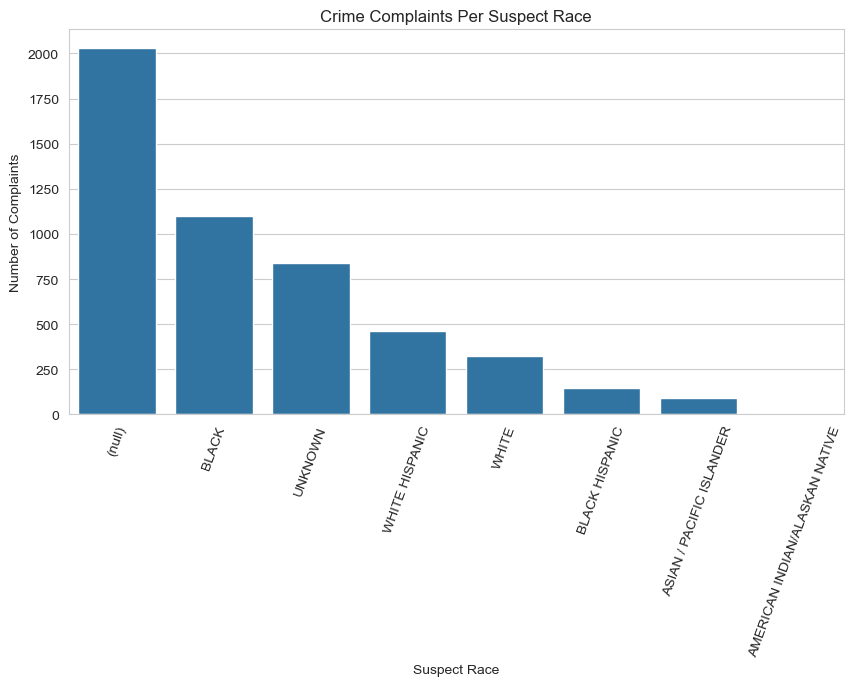

In [125]:
# Plot bar chart of number of complaints per suspect race

x = data_sample['SUSP_RACE'].value_counts().index
y = data_sample['SUSP_RACE'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Race')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Race')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

This would also have to be compared to the demographics of New Yorkers in all 5 boroughs

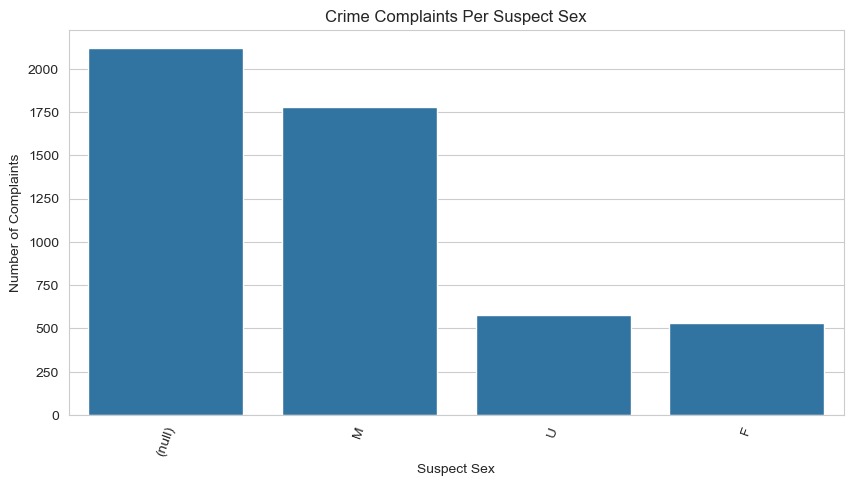

In [126]:
# Plot bar chart of number of complaints per suspect sex

x = data_sample['SUSP_SEX'].value_counts().index
y = data_sample['SUSP_SEX'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Sex')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Sex')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

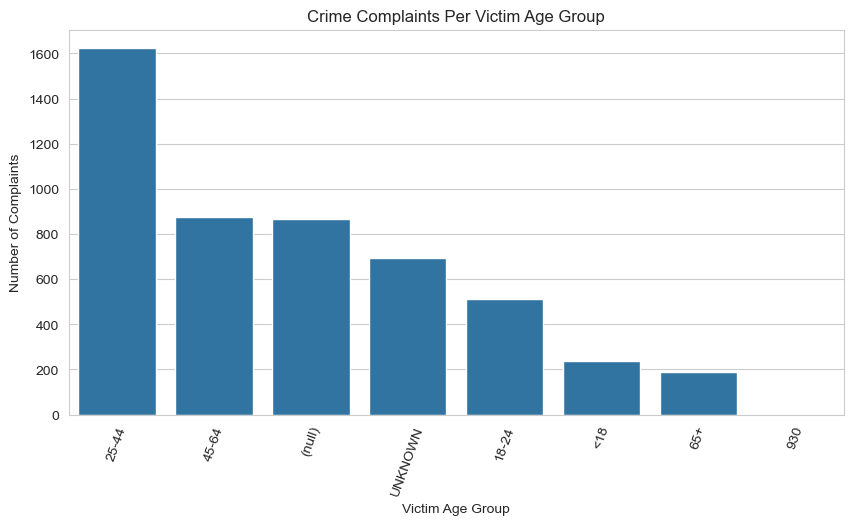

In [134]:
# Plot bar chart of number of complaints per victim age group

x = data_sample['VIC_AGE_GROUP'].value_counts().index
y = data_sample['VIC_AGE_GROUP'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Age Group')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Age Group')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

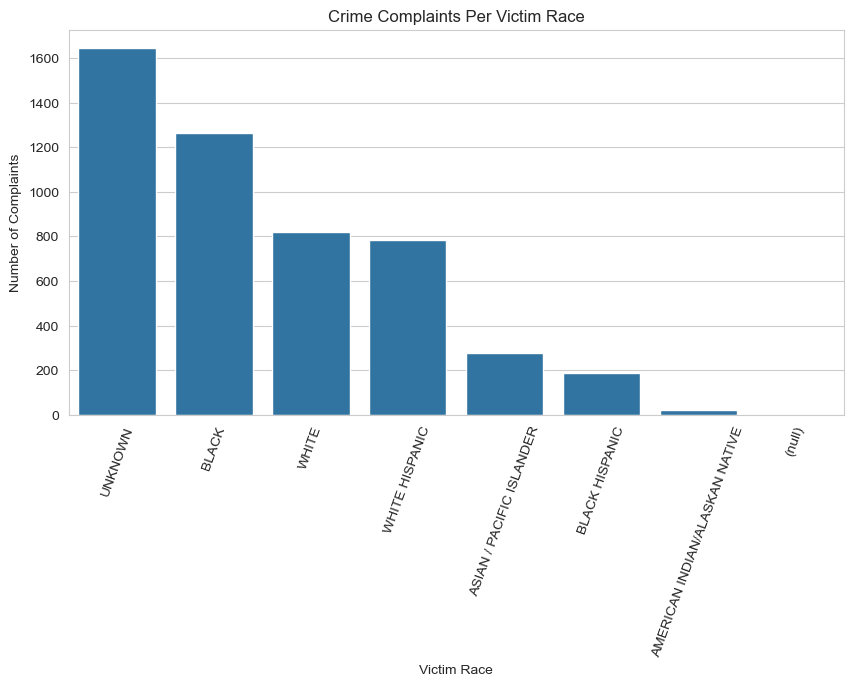

In [135]:
# Plot bar chart of number of complaints per victim race

x = data_sample['VIC_RACE'].value_counts().index
y = data_sample['VIC_RACE'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Race')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Race')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

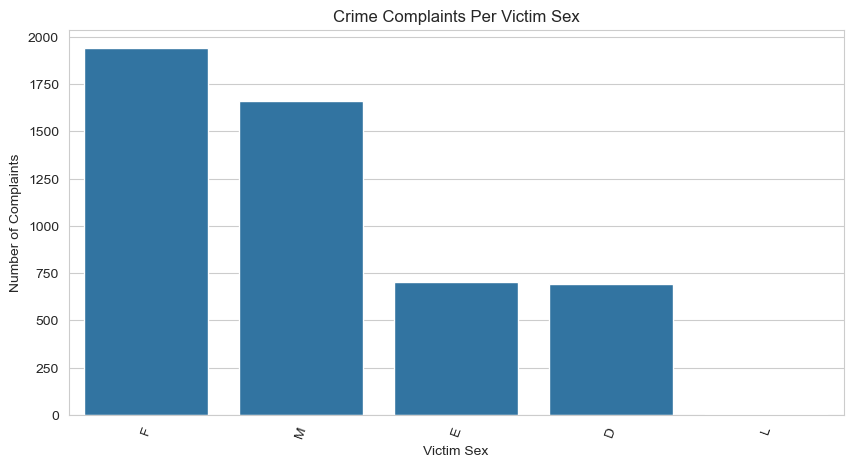

In [136]:
# Plot bar chart of number of complaints per victim sex

x = data_sample['VIC_SEX'].value_counts().index
y = data_sample['VIC_SEX'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Sex')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Sex')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

In [123]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2002-09-01 to 2023-12-30
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CMPLNT_NUM         5000 non-null   object        
 1   CMPLNT_FR_DT       5000 non-null   datetime64[ns]
 2   CMPLNT_FR_TM       5000 non-null   object        
 3   CMPLNT_TO_DT       3940 non-null   object        
 4   CMPLNT_TO_TM       5000 non-null   object        
 5   ADDR_PCT_CD        5000 non-null   float64       
 6   RPT_DT             5000 non-null   object        
 7   KY_CD              5000 non-null   int64         
 8   OFNS_DESC          5000 non-null   object        
 9   PD_CD              4996 non-null   float64       
 10  PD_DESC            5000 non-null   object        
 11  CRM_ATPT_CPTD_CD   5000 non-null   object        
 12  LAW_CAT_CD         5000 non-null   object        
 13  BORO_NM            5000 non-null   object    

## Data Preparation

In [194]:
print(data_sample_weekly.head(15), data_sample_weekly.tail(15))

CMPLNT_FR_DT
2002-09-01    1
2002-09-08    0
2002-09-15    0
2002-09-22    0
2002-09-29    0
2002-10-06    0
2002-10-13    0
2002-10-20    0
2002-10-27    0
2002-11-03    0
2002-11-10    0
2002-11-17    0
2002-11-24    0
2002-12-01    0
2002-12-08    0
Freq: W-SUN, Name: CMPLNT_FR_DT, dtype: int64 CMPLNT_FR_DT
2023-09-24     6
2023-10-01    11
2023-10-08     4
2023-10-15     7
2023-10-22     7
2023-10-29     7
2023-11-05     5
2023-11-12     6
2023-11-19     4
2023-11-26     7
2023-12-03     8
2023-12-10     5
2023-12-17     6
2023-12-24     6
2023-12-31     6
Freq: W-SUN, Name: CMPLNT_FR_DT, dtype: int64


According to the graph and the list of the first 15 datapoints in `data_sample_weekly`, the beginning of the data is not reliable. There are many missing datapoints. The description of the data states that it begins in the year 2006, so I will remove all datapoints before that year.

In [203]:
# Remove any entries before year 2006
data_sample_weekly = data_sample_weekly[data_sample_weekly.index.year>=2006]

In [204]:
# Check if any weeks have 0 complaints
data_sample_weekly.value_counts()

CMPLNT_FR_DT
4     154
6     152
5     148
3     118
7      93
8      87
2      63
9      43
1      34
10     20
11     12
12      7
0       5
13      3
18      1
Name: count, dtype: int64

In [206]:
# Look at which weeks have 0 complaints
data_sample_weekly[data_sample_weekly==0]

CMPLNT_FR_DT
2011-07-17    0
2017-01-22    0
2020-04-26    0
2020-12-20    0
2021-08-08    0
Name: CMPLNT_FR_DT, dtype: int64

In [161]:
def display_df(dftest):
    '''
    Display the output from a Dickey-Fuller test in a more readable format
    '''
    
    
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)
    
    print(f"The p-value associated with the Dickey-Fuller statistical test is {dfoutput['p-value']},")
    if dfoutput['p-value'] < 0.05:
        print(" so we can safely assume that the differenced data is stationary.")
    else:
        print(" so we cannot reject the null hypothesis that the differenced data is \
    not stationary.")

## Feature Engineering

## Train Test Split (Edit title name)

In [163]:
# Find the index which allows us to split off 20% of the data
cutoff = round(data_sample_weekly.shape[0]*0.8)
cutoff

891

In [164]:
# Define train and test sets according to cutoff index above
train = data_sample_weekly[:cutoff]

test = data_sample_weekly[cutoff:]

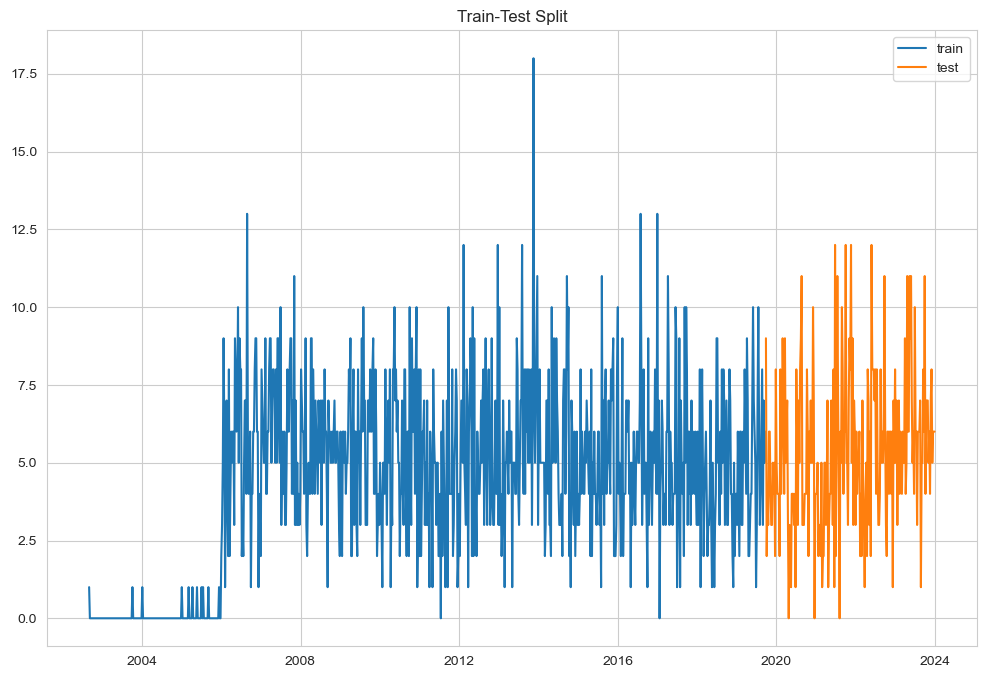

In [165]:
# Plot time series with cutoff highlighted
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [166]:
# Complete a train test split with TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150]
Test  index: [151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239

# Modeling

## Baseline Model

In [170]:
# Create baseline model with shift operator
naive = train.shift(1)
naive

CMPLNT_FR_DT
2002-09-01    NaN
2002-09-08    1.0
2002-09-15    0.0
2002-09-22    0.0
2002-09-29    0.0
             ... 
2019-08-25    6.0
2019-09-01    8.0
2019-09-08    3.0
2019-09-15    7.0
2019-09-22    5.0
Freq: W-SUN, Name: CMPLNT_FR_DT, Length: 891, dtype: float64

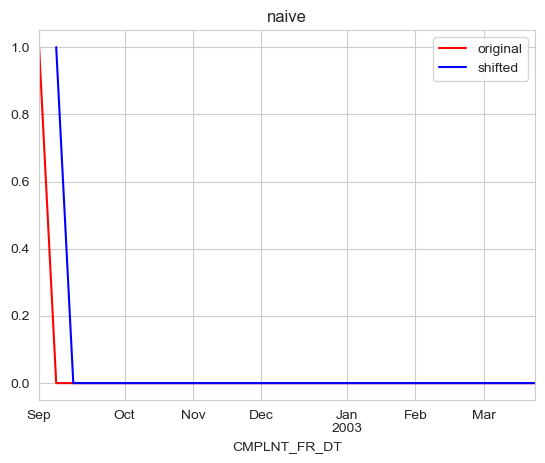

In [171]:
# Plot baseline model
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [172]:
# Calculate RMSE for baseline model
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

2.905051779692856

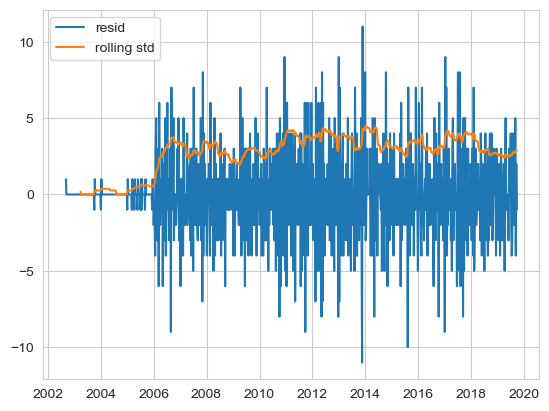

In [173]:
# 
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).std(), label='rolling std')
ax.legend();

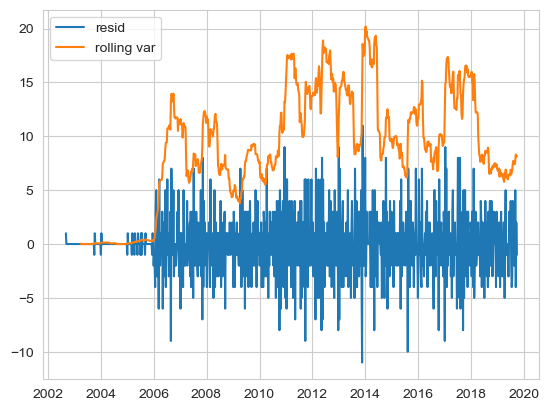

In [174]:
# 
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).var(), label='rolling var')
ax.legend();

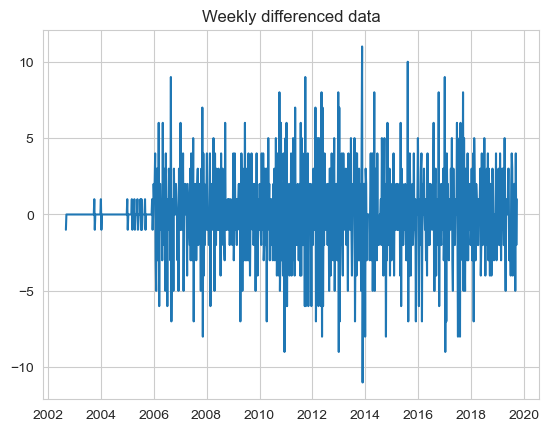

In [175]:
# Visualize differenced data
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

## Model Iterations

## Final Model

# Conclusion

## Limitations

## Next Steps